In [1]:
import numpy as np
import torch
import torch.nn as nn
import timm
import pandas as pd
from pathlib import Path
import soundfile as sf
from  soundfile import SoundFile
import librosa as lb
import librosa.display as lbd
import concurrent.futures

In [2]:
# config
import torch
import torch.nn.functional as F

class CFG:
    seed = 42
    num_classes = 206
    batch_size = 128
    epochs = 30
    PRECISION = 16    
    PATIENCE = 8    
    img_size = [224,224]
    model = "eca_nfnet_l0"
    pretrained = False            
    weight_decay = 1e-3
    use_mixup = True
    mixup_alpha = 0.2   
    use_spec_aug = False
    p_spec_aug = 0.5
    time_shift_prob = 0.5
    gn_prob = 0.5
    infer_duration = 5
    fmin = 50
    fmax = 14000
    mel_bins = 192
    window_size = 1024
    hop_size = 512
    use_fsr = False

    device = torch.device('cpu')  

    train_path = "/root/projects/BirdClef2025/data/train.csv"
    valid_path = "/root/projects/BirdClef2025/data/valid.csv"
    test_path = '/root/projects/BirdClef2025/data/train_soundscapes/'
    sample_rate = 32000
    duration = 5
    max_read_samples = 10
    lr = 5e-5

    scheduler     = 'CosineAnnealingLR'
    min_lr        = 5e-7
    T_max         = int(30000/batch_size*epochs)+50
    T_0           = 25

    n_accumulate = 4
    
    target_columns = "abethr1 abhori1 abythr1 afbfly1 afdfly1 afecuc1 affeag1 afgfly1 afghor1 afmdov1 afpfly1 afpkin1 afpwag1 afrgos1 afrgrp1 afrjac1 afrthr1 amesun2 augbuz1 bagwea1 barswa bawhor2 bawman1 bcbeat1 beasun2 bkctch1 bkfruw1 blacra1 blacuc1 blakit1 blaplo1 blbpuf2 blcapa2 blfbus1 blhgon1 blhher1 blksaw1 blnmou1 blnwea1 bltapa1 bltbar1 bltori1 blwlap1 brcale1 brcsta1 brctch1 brcwea1 brican1 brobab1 broman1 brosun1 brrwhe3 brtcha1 brubru1 brwwar1 bswdov1 btweye2 bubwar2 butapa1 cabgre1 carcha1 carwoo1 categr ccbeat1 chespa1 chewea1 chibat1 chtapa3 chucis1 cibwar1 cohmar1 colsun2 combul2 combuz1 comsan crefra2 crheag1 crohor1 darbar1 darter3 didcuc1 dotbar1 dutdov1 easmog1 eaywag1 edcsun3 egygoo equaka1 eswdov1 eubeat1 fatrav1 fatwid1 fislov1 fotdro5 gabgos2 gargan gbesta1 gnbcam2 gnhsun1 gobbun1 gobsta5 gobwea1 golher1 grbcam1 grccra1 grecor greegr grewoo2 grwpyt1 gryapa1 grywrw1 gybfis1 gycwar3 gyhbus1 gyhkin1 gyhneg1 gyhspa1 gytbar1 hadibi1 hamerk1 hartur1 helgui hipbab1 hoopoe huncis1 hunsun2 joygre1 kerspa2 klacuc1 kvbsun1 laudov1 lawgol lesmaw1 lessts1 libeat1 litegr litswi1 litwea1 loceag1 lotcor1 lotlap1 luebus1 mabeat1 macshr1 malkin1 marsto1 marsun2 mcptit1 meypar1 moccha1 mouwag1 ndcsun2 nobfly1 norbro1 norcro1 norfis1 norpuf1 nubwoo1 pabspa1 palfly2 palpri1 piecro1 piekin1 pitwhy purgre2 pygbat1 quailf1 ratcis1 raybar1 rbsrob1 rebfir2 rebhor1 reboxp1 reccor reccuc1 reedov1 refbar2 refcro1 reftin1 refwar2 rehblu1 rehwea1 reisee2 rerswa1 rewsta1 rindov rocmar2 rostur1 ruegls1 rufcha2 sacibi2 sccsun2 scrcha1 scthon1 shesta1 sichor1 sincis1 slbgre1 slcbou1 sltnig1 sobfly1 somgre1 somtit4 soucit1 soufis1 spemou2 spepig1 spewea1 spfbar1 spfwea1 spmthr1 spwlap1 squher1 strher strsee1 stusta1 subbus1 supsta1 tacsun1 tafpri1 tamdov1 thrnig1 trobou1 varsun2 vibsta2 vilwea1 vimwea1 walsta1 wbgbir1 wbrcha2 wbswea1 wfbeat1 whbcan1 whbcou1 whbcro2 whbtit5 whbwea1 whbwhe3 whcpri2 whctur2 wheslf1 whhsaw1 whihel1 whrshr1 witswa1 wlwwar wookin1 woosan wtbeat1 yebapa1 yebbar1 yebduc1 yebere1 yebgre1 yebsto1 yeccan1 yefcan yelbis1 yenspu1 yertin1 yesbar1 yespet1 yetgre1 yewgre1".split()

In [3]:
import math
import argparse

import librosa
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter


class DFTBase(nn.Module):
    def __init__(self):
        r"""Base class for DFT and IDFT matrix.
        """
        super(DFTBase, self).__init__()

    def dft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(-2 * np.pi * 1j / n)
        W = np.power(omega, x * y)  # shape: (n, n)
        return W

    def idft_matrix(self, n):
        (x, y) = np.meshgrid(np.arange(n), np.arange(n))
        omega = np.exp(2 * np.pi * 1j / n)
        W = np.power(omega, x * y)  # shape: (n, n)
        return W


class DFT(DFTBase):
    def __init__(self, n, norm):
        r"""Calculate discrete Fourier transform (DFT), inverse DFT (IDFT, 
        right DFT (RDFT) RDFT, and inverse RDFT (IRDFT.) 

        Args:
          n: fft window size
          norm: None | 'ortho'
        """
        super(DFT, self).__init__()

        self.W = self.dft_matrix(n)
        self.inv_W = self.idft_matrix(n)

        self.W_real = torch.Tensor(np.real(self.W))
        self.W_imag = torch.Tensor(np.imag(self.W))
        self.inv_W_real = torch.Tensor(np.real(self.inv_W))
        self.inv_W_imag = torch.Tensor(np.imag(self.inv_W))

        self.n = n
        self.norm = norm

    def dft(self, x_real, x_imag):
        r"""Calculate DFT of a signal.

        Args:
            x_real: (n,), real part of a signal
            x_imag: (n,), imag part of a signal

        Returns:
            z_real: (n,), real part of output
            z_imag: (n,), imag part of output
        """
        z_real = torch.matmul(x_real, self.W_real) - torch.matmul(x_imag, self.W_imag)
        z_imag = torch.matmul(x_imag, self.W_real) + torch.matmul(x_real, self.W_imag)
        # shape: (n,)

        if self.norm is None:
            pass
        elif self.norm == 'ortho':
            z_real /= math.sqrt(self.n)
            z_imag /= math.sqrt(self.n)

        return z_real, z_imag

    def idft(self, x_real, x_imag):
        r"""Calculate IDFT of a signal.

        Args:
            x_real: (n,), real part of a signal
            x_imag: (n,), imag part of a signal
        Returns:
            z_real: (n,), real part of output
            z_imag: (n,), imag part of output
        """
        z_real = torch.matmul(x_real, self.inv_W_real) - torch.matmul(x_imag, self.inv_W_imag)
        z_imag = torch.matmul(x_imag, self.inv_W_real) + torch.matmul(x_real, self.inv_W_imag)
        # shape: (n,)

        if self.norm is None:
            z_real /= self.n
        elif self.norm == 'ortho':
            z_real /= math.sqrt(n)
            z_imag /= math.sqrt(n)

        return z_real, z_imag

    def rdft(self, x_real):
        r"""Calculate right RDFT of signal.

        Args:
            x_real: (n,), real part of a signal
            x_imag: (n,), imag part of a signal

        Returns:
            z_real: (n // 2 + 1,), real part of output
            z_imag: (n // 2 + 1,), imag part of output
        """
        n_rfft = self.n // 2 + 1
        z_real = torch.matmul(x_real, self.W_real[..., 0 : n_rfft])
        z_imag = torch.matmul(x_real, self.W_imag[..., 0 : n_rfft])
        # shape: (n // 2 + 1,)

        if self.norm is None:
            pass
        elif self.norm == 'ortho':
            z_real /= math.sqrt(self.n)
            z_imag /= math.sqrt(self.n)

        return z_real, z_imag

    def irdft(self, x_real, x_imag):
        r"""Calculate IRDFT of signal.
        
        Args:
            x_real: (n // 2 + 1,), real part of a signal
            x_imag: (n // 2 + 1,), imag part of a signal

        Returns:
            z_real: (n,), real part of output
            z_imag: (n,), imag part of output
        """
        n_rfft = self.n // 2 + 1

        flip_x_real = torch.flip(x_real, dims=(-1,))
        flip_x_imag = torch.flip(x_imag, dims=(-1,))
        # shape: (n // 2 + 1,)

        x_real = torch.cat((x_real, flip_x_real[..., 1 : n_rfft - 1]), dim=-1)
        x_imag = torch.cat((x_imag, -1. * flip_x_imag[..., 1 : n_rfft - 1]), dim=-1)
        # shape: (n,)

        z_real = torch.matmul(x_real, self.inv_W_real) - torch.matmul(x_imag, self.inv_W_imag)
        # shape: (n,)

        if self.norm is None:
            z_real /= self.n
        elif self.norm == 'ortho':
            z_real /= math.sqrt(n)

        return z_real


class STFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None,
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        r"""PyTorch implementation of STFT with Conv1d. The function has the 
        same output as librosa.stft.

        Args:
            n_fft: int, fft window size, e.g., 2048
            hop_length: int, hop length samples, e.g., 441
            win_length: int, window length e.g., 2048
            window: str, window function name, e.g., 'hann'
            center: bool
            pad_mode: str, e.g., 'reflect'
            freeze_parameters: bool, set to True to freeze all parameters. Set
                to False to finetune all parameters.
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame.
        if self.win_length is None:
            self.win_length = n_fft

        # Set the default hop, if it's not already specified.
        if self.hop_length is None:
            self.hop_length = int(self.win_length // 4)

        fft_window = librosa.filters.get_window(window, self.win_length, fftbins=True)

        # Pad the window out to n_fft size.
        fft_window = librosa.util.pad_center(fft_window, size=n_fft)

        # DFT & IDFT matrix.
        self.W = self.dft_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv1d(in_channels=1, out_channels=out_channels,
            kernel_size=n_fft, stride=self.hop_length, padding=0, dilation=1,
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=1, out_channels=out_channels,
            kernel_size=n_fft, stride=self.hop_length, padding=0, dilation=1,
            groups=1, bias=False)

        # Initialize Conv1d weights.
        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T)[:, None, :]
        # (n_fft // 2 + 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        r"""Calculate STFT of batch of signals.

        Args: 
            input: (batch_size, data_length), input signals.

        Returns:
            real: (batch_size, 1, time_steps, n_fft // 2 + 1)
            imag: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        x = input[:, None, :]   # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, n_fft // 2 + 1, time_steps)

        real = real[:, None, :, :].transpose(2, 3)
        imag = imag[:, None, :, :].transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag


def magphase(real, imag):
    r"""Calculate magnitude and phase from real and imag part of signals.

    Args:
        real: tensor, real part of signals
        imag: tensor, imag part of signals

    Returns:
        mag: tensor, magnitude of signals
        cos: tensor, cosine of phases of signals
        sin: tensor, sine of phases of signals
    """
    mag = (real ** 2 + imag ** 2) ** 0.5
    cos = real / torch.clamp(mag, 1e-10, np.inf)
    sin = imag / torch.clamp(mag, 1e-10, np.inf)

    return mag, cos, sin


class ISTFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None,
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True, 
        onnx=False, frames_num=None, device=None):
        """PyTorch implementation of ISTFT with Conv1d. The function has the 
        same output as librosa.istft.

        Args:
            n_fft: int, fft window size, e.g., 2048
            hop_length: int, hop length samples, e.g., 441
            win_length: int, window length e.g., 2048
            window: str, window function name, e.g., 'hann'
            center: bool
            pad_mode: str, e.g., 'reflect'
            freeze_parameters: bool, set to True to freeze all parameters. Set
                to False to finetune all parameters.
            onnx: bool, set to True when exporting trained model to ONNX. This
                will replace several operations to operators supported by ONNX.
            frames_num: None | int, number of frames of audio clips to be 
                inferneced. Only useable when onnx=True.
            device: None | str, device of ONNX. Only useable when onnx=True.
        """
        super(ISTFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        if not onnx:
            assert frames_num is None, "When onnx=False, frames_num must be None!"
            assert device is None, "When onnx=False, device must be None!"

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.center = center
        self.pad_mode = pad_mode
        self.onnx = onnx

        # By default, use the entire frame.
        if self.win_length is None:
            self.win_length = self.n_fft

        # Set the default hop, if it's not already specified.
        if self.hop_length is None:
            self.hop_length = int(self.win_length // 4)

        # Initialize Conv1d modules for calculating real and imag part of DFT.
        self.init_real_imag_conv()

        # Initialize overlap add window for reconstruct time domain signals.
        self.init_overlap_add_window()

        if self.onnx:
            # Initialize ONNX modules.
            self.init_onnx_modules(frames_num, device)
        
        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def init_real_imag_conv(self):
        r"""Initialize Conv1d for calculating real and imag part of DFT.
        """
        self.W = self.idft_matrix(self.n_fft) / self.n_fft

        self.conv_real = nn.Conv1d(in_channels=self.n_fft, out_channels=self.n_fft,
            kernel_size=1, stride=1, padding=0, dilation=1,
            groups=1, bias=False)

        self.conv_imag = nn.Conv1d(in_channels=self.n_fft, out_channels=self.n_fft,
            kernel_size=1, stride=1, padding=0, dilation=1,
            groups=1, bias=False)

        ifft_window = librosa.filters.get_window(self.window, self.win_length, fftbins=True)
        # (win_length,)

        # Pad the window to n_fft
        ifft_window = librosa.util.pad_center(ifft_window, size=self.n_fft)

        self.conv_real.weight.data = torch.Tensor(
            np.real(self.W * ifft_window[None, :]).T)[:, :, None]
        # (n_fft // 2 + 1, 1, n_fft)

        self.conv_imag.weight.data = torch.Tensor(
            np.imag(self.W * ifft_window[None, :]).T)[:, :, None]
        # (n_fft // 2 + 1, 1, n_fft)

    def init_overlap_add_window(self):
        r"""Initialize overlap add window for reconstruct time domain signals.
        """
        
        ola_window = librosa.filters.get_window(self.window, self.win_length, fftbins=True)
        # (win_length,)

        ola_window = librosa.util.normalize(ola_window, norm=None) ** 2
        ola_window = librosa.util.pad_center(ola_window, size=self.n_fft)
        ola_window = torch.Tensor(ola_window)

        self.register_buffer('ola_window', ola_window)
        # (win_length,)

    def init_onnx_modules(self, frames_num, device):
        r"""Initialize ONNX modules.

        Args:
            frames_num: int
            device: str | None
        """

        # Use Conv1d to implement torch.flip(), because torch.flip() is not 
        # supported by ONNX.
        self.reverse = nn.Conv1d(in_channels=self.n_fft // 2 + 1,
            out_channels=self.n_fft // 2 - 1, kernel_size=1, bias=False)

        tmp = np.zeros((self.n_fft // 2 - 1, self.n_fft // 2 + 1, 1))
        tmp[:, 1 : -1, 0] = np.array(np.eye(self.n_fft // 2 - 1)[::-1])
        self.reverse.weight.data = torch.Tensor(tmp)
        # (n_fft // 2 - 1, n_fft // 2 + 1, 1)

        # Use nn.ConvTranspose2d to implement torch.nn.functional.fold(), 
        # because torch.nn.functional.fold() is not supported by ONNX.
        self.overlap_add = nn.ConvTranspose2d(in_channels=self.n_fft,
            out_channels=1, kernel_size=(self.n_fft, 1), stride=(self.hop_length, 1), bias=False)

        self.overlap_add.weight.data = torch.Tensor(np.eye(self.n_fft)[:, None, :, None])
        # (n_fft, 1, n_fft, 1)

        if frames_num:
            # Pre-calculate overlap-add window sum for reconstructing signals
            # when using ONNX.
            self.ifft_window_sum = self._get_ifft_window_sum_onnx(frames_num, device)
        else:
            self.ifft_window_sum = []

    def forward(self, real_stft, imag_stft, length):
        r"""Calculate inverse STFT.

        Args:
            real_stft: (batch_size, channels=1, time_steps, n_fft // 2 + 1)
            imag_stft: (batch_size, channels=1, time_steps, n_fft // 2 + 1)
            length: int
        
        Returns:
            real: (batch_size, data_length), output signals.
        """
        assert real_stft.ndimension() == 4 and imag_stft.ndimension() == 4
        batch_size, _, frames_num, _ = real_stft.shape

        real_stft = real_stft[:, 0, :, :].transpose(1, 2)
        imag_stft = imag_stft[:, 0, :, :].transpose(1, 2)
        # (batch_size, n_fft // 2 + 1, time_steps)

        # Get full stft representation from spectrum using symmetry attribute.
        if self.onnx:
            full_real_stft, full_imag_stft = self._get_full_stft_onnx(real_stft, imag_stft)
        else:
            full_real_stft, full_imag_stft = self._get_full_stft(real_stft, imag_stft)
        # full_real_stft: (batch_size, n_fft, time_steps)
        # full_imag_stft: (batch_size, n_fft, time_steps)

        # Calculate IDFT frame by frame.
        s_real = self.conv_real(full_real_stft) - self.conv_imag(full_imag_stft)
        # (batch_size, n_fft, time_steps)

        # Overlap add signals in frames to reconstruct signals.
        if self.onnx:
            y = self._overlap_add_divide_window_sum_onnx(s_real, frames_num)
        else:
            y = self._overlap_add_divide_window_sum(s_real, frames_num)
        # y: (batch_size, audio_samples + win_length,)
        
        y = self._trim_edges(y, length)
        # (batch_size, audio_samples,)
            
        return y

    def _get_full_stft(self, real_stft, imag_stft):
        r"""Get full stft representation from spectrum using symmetry attribute.

        Args:
            real_stft: (batch_size, n_fft // 2 + 1, time_steps)
            imag_stft: (batch_size, n_fft // 2 + 1, time_steps)

        Returns:
            full_real_stft: (batch_size, n_fft, time_steps)
            full_imag_stft: (batch_size, n_fft, time_steps)
        """
        full_real_stft = torch.cat((real_stft, torch.flip(real_stft[:, 1 : -1, :], dims=[1])), dim=1)
        full_imag_stft = torch.cat((imag_stft, - torch.flip(imag_stft[:, 1 : -1, :], dims=[1])), dim=1)

        return full_real_stft, full_imag_stft

    def _get_full_stft_onnx(self, real_stft, imag_stft):
        r"""Get full stft representation from spectrum using symmetry attribute
        for ONNX. Replace several pytorch operations in self._get_full_stft() 
        that are not supported by ONNX.

        Args:
            real_stft: (batch_size, n_fft // 2 + 1, time_steps)
            imag_stft: (batch_size, n_fft // 2 + 1, time_steps)

        Returns:
            full_real_stft: (batch_size, n_fft, time_steps)
            full_imag_stft: (batch_size, n_fft, time_steps)
        """

        # Implement torch.flip() with Conv1d.
        full_real_stft = torch.cat((real_stft, self.reverse(real_stft)), dim=1)
        full_imag_stft = torch.cat((imag_stft, - self.reverse(imag_stft)), dim=1)

        return full_real_stft, full_imag_stft

    def _overlap_add_divide_window_sum(self, s_real, frames_num):
        r"""Overlap add signals in frames to reconstruct signals.

        Args:
            s_real: (batch_size, n_fft, time_steps), signals in frames
            frames_num: int

        Returns:
            y: (batch_size, audio_samples)
        """
        
        output_samples = (s_real.shape[-1] - 1) * self.hop_length + self.win_length
        # (audio_samples,)

        # Overlap-add signals in frames to signals. Ref: 
        # asteroid_filterbanks.torch_stft_fb.torch_stft_fb() from
        # https://github.com/asteroid-team/asteroid-filterbanks
        y = torch.nn.functional.fold(input=s_real, output_size=(1, output_samples), 
            kernel_size=(1, self.win_length), stride=(1, self.hop_length))
        # (batch_size, 1, 1, audio_samples,)
        
        y = y[:, 0, 0, :]
        # (batch_size, audio_samples)

        # Get overlap-add window sum to be divided.
        ifft_window_sum = self._get_ifft_window(frames_num)
        # (audio_samples,)

        # Following code is abandaned for divide overlap-add window, because
        # not supported by half precision training and ONNX.
        # min_mask = ifft_window_sum.abs() < 1e-11
        # y[:, ~min_mask] = y[:, ~min_mask] / ifft_window_sum[None, ~min_mask]
        # # (batch_size, audio_samples)

        ifft_window_sum = torch.clamp(ifft_window_sum, 1e-11, np.inf)
        # (audio_samples,)

        y = y / ifft_window_sum[None, :]
        # (batch_size, audio_samples,)

        return y

    def _get_ifft_window(self, frames_num):
        r"""Get overlap-add window sum to be divided.

        Args:
            frames_num: int

        Returns:
            ifft_window_sum: (audio_samlpes,), overlap-add window sum to be 
            divided.
        """
        
        output_samples = (frames_num - 1) * self.hop_length + self.win_length
        # (audio_samples,)

        window_matrix = self.ola_window[None, :, None].repeat(1, 1, frames_num)
        # (batch_size, win_length, time_steps)

        ifft_window_sum = F.fold(input=window_matrix, 
            output_size=(1, output_samples), kernel_size=(1, self.win_length), 
            stride=(1, self.hop_length))
        # (1, 1, 1, audio_samples)
        
        ifft_window_sum = ifft_window_sum.squeeze()
        # (audio_samlpes,)

        return ifft_window_sum

    def _overlap_add_divide_window_sum_onnx(self, s_real, frames_num):
        r"""Overlap add signals in frames to reconstruct signals for ONNX. 
        Replace several pytorch operations in 
        self._overlap_add_divide_window_sum() that are not supported by ONNX.

        Args:
            s_real: (batch_size, n_fft, time_steps), signals in frames
            frames_num: int

        Returns:
            y: (batch_size, audio_samples)
        """

        s_real = s_real[..., None]
        # (batch_size, n_fft, time_steps, 1)

        # Implement overlap-add with Conv1d, because torch.nn.functional.fold()
        # is not supported by ONNX.
        y = self.overlap_add(s_real)[:, 0, :, 0]    
        # y: (batch_size, samples_num)
        
        if len(self.ifft_window_sum) != y.shape[1]:
            device = s_real.device

            self.ifft_window_sum = self._get_ifft_window_sum_onnx(frames_num, device)
            # (audio_samples,)

        # Use torch.clamp() to prevent from underflow to make sure all 
        # operations are supported by ONNX.
        ifft_window_sum = torch.clamp(self.ifft_window_sum, 1e-11, np.inf)
        # (audio_samples,)

        y = y / ifft_window_sum[None, :]
        # (batch_size, audio_samples,)
        
        return y

    def _get_ifft_window_sum_onnx(self, frames_num, device):
        r"""Pre-calculate overlap-add window sum for reconstructing signals when
        using ONNX.

        Args:
            frames_num: int
            device: str | None

        Returns:
            ifft_window_sum: (audio_samples,)
        """
        
        ifft_window_sum = librosa.filters.window_sumsquare(window=self.window, 
            n_frames=frames_num, win_length=self.win_length, n_fft=self.n_fft, 
            hop_length=self.hop_length)
        # (audio_samples,)

        ifft_window_sum = torch.Tensor(ifft_window_sum)

        if device:
            ifft_window_sum = ifft_window_sum.to(device)

        return ifft_window_sum

    def _trim_edges(self, y, length):
        r"""Trim audio.

        Args:
            y: (audio_samples,)
            length: int

        Returns:
            (trimmed_audio_samples,)
        """
        # Trim or pad to length
        if length is None:
            if self.center:
                y = y[:, self.n_fft // 2 : -self.n_fft // 2]
        else:
            if self.center:
                start = self.n_fft // 2
            else:
                start = 0

            y = y[:, start : start + length]

        return y


class Spectrogram(nn.Module):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None,
        window='hann', center=True, pad_mode='reflect', power=2.0,
        freeze_parameters=True):
        r"""Calculate spectrogram using pytorch. The STFT is implemented with 
        Conv1d. The function has the same output of librosa.stft
        """
        super(Spectrogram, self).__init__()

        self.power = power

        self.stft = STFT(n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center,
            pad_mode=pad_mode, freeze_parameters=True)

    def forward(self, input):
        r"""Calculate spectrogram of input signals.
        Args: 
            input: (batch_size, data_length)

        Returns:
            spectrogram: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        (real, imag) = self.stft.forward(input)
        # (batch_size, n_fft // 2 + 1, time_steps)

        spectrogram = real ** 2 + imag ** 2

        if self.power == 2.0:
            pass
        else:
            spectrogram = spectrogram ** (self.power / 2.0)

        return spectrogram


class LogmelFilterBank(nn.Module):
    def __init__(self, sr=22050, n_fft=2048, n_mels=64, fmin=0.0, fmax=None, 
        is_log=True, ref=1.0, amin=1e-10, top_db=80.0, freeze_parameters=True):
        r"""Calculate logmel spectrogram using pytorch. The mel filter bank is 
        the pytorch implementation of as librosa.filters.mel 
        """
        super(LogmelFilterBank, self).__init__()

        self.is_log = is_log
        self.ref = ref
        self.amin = amin
        self.top_db = top_db
        if fmax == None:
            fmax = sr//2

        self.melW = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T
        # (n_fft // 2 + 1, mel_bins)

        self.melW = nn.Parameter(torch.Tensor(self.melW))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        r"""Calculate (log) mel spectrogram from spectrogram.

        Args:
            input: (*, n_fft), spectrogram
        
        Returns: 
            output: (*, mel_bins), (log) mel spectrogram
        """

        # Mel spectrogram
        mel_spectrogram = torch.matmul(input, self.melW)
        # (*, mel_bins)

        # Logmel spectrogram
        if self.is_log:
            output = self.power_to_db(mel_spectrogram)
        else:
            output = mel_spectrogram

        return output


    def power_to_db(self, input):
        r"""Power to db, this function is the pytorch implementation of 
        librosa.power_to_lb
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max().item() - self.top_db, max=np.inf)

        return log_spec


class Enframe(nn.Module):
    def __init__(self, frame_length=2048, hop_length=512):
        r"""Enframe a time sequence. This function is the pytorch implementation 
        of librosa.util.frame
        """
        super(Enframe, self).__init__()

        self.enframe_conv = nn.Conv1d(in_channels=1, out_channels=frame_length,
            kernel_size=frame_length, stride=hop_length,
            padding=0, bias=False)

        self.enframe_conv.weight.data = torch.Tensor(torch.eye(frame_length)[:, None, :])
        self.enframe_conv.weight.requires_grad = False

    def forward(self, input):
        r"""Enframe signals into frames.
        Args:
            input: (batch_size, samples)
        
        Returns: 
            output: (batch_size, window_length, frames_num)
        """
        output = self.enframe_conv(input[:, None, :])
        return output


    def power_to_db(self, input):
        r"""Power to db, this function is the pytorch implementation of 
        librosa.power_to_lb.
        """
        ref_value = self.ref
        log_spec = 10.0 * torch.log10(torch.clamp(input, min=self.amin, max=np.inf))
        log_spec -= 10.0 * np.log10(np.maximum(self.amin, ref_value))

        if self.top_db is not None:
            if self.top_db < 0:
                raise librosa.util.exceptions.ParameterError('top_db must be non-negative')
            log_spec = torch.clamp(log_spec, min=log_spec.max() - self.top_db, max=np.inf)

        return log_spec


class Scalar(nn.Module):
    def __init__(self, scalar, freeze_parameters):
        super(Scalar, self).__init__()

        self.scalar_mean = Parameter(torch.Tensor(scalar['mean']))
        self.scalar_std = Parameter(torch.Tensor(scalar['std']))

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        return (input - self.scalar_mean) / self.scalar_std


def debug(select, device):
    """Compare numpy + librosa and torchlibrosa results. For debug. 

    Args:
        select: 'dft' | 'logmel'
        device: 'cpu' | 'cuda'
    """

    if select == 'dft':
        n = 10
        norm = None     # None | 'ortho'
        np.random.seed(0)

        # Data
        np_data = np.random.uniform(-1, 1, n)
        pt_data = torch.Tensor(np_data)

        # Numpy FFT
        np_fft = np.fft.fft(np_data, norm=norm)
        np_ifft = np.fft.ifft(np_fft, norm=norm)
        np_rfft = np.fft.rfft(np_data, norm=norm)
        np_irfft = np.fft.ifft(np_rfft, norm=norm)

        # Pytorch FFT
        obj = DFT(n, norm)
        pt_dft = obj.dft(pt_data, torch.zeros_like(pt_data))
        pt_idft = obj.idft(pt_dft[0], pt_dft[1])
        pt_rdft = obj.rdft(pt_data)
        pt_irdft = obj.irdft(pt_rdft[0], pt_rdft[1])

        print('Comparing librosa and pytorch implementation of DFT. All numbers '
            'below should be close to 0.')
        print(np.mean((np.abs(np.real(np_fft) - pt_dft[0].cpu().numpy()))))
        print(np.mean((np.abs(np.imag(np_fft) - pt_dft[1].cpu().numpy()))))

        print(np.mean((np.abs(np.real(np_ifft) - pt_idft[0].cpu().numpy()))))
        print(np.mean((np.abs(np.imag(np_ifft) - pt_idft[1].cpu().numpy()))))

        print(np.mean((np.abs(np.real(np_rfft) - pt_rdft[0].cpu().numpy()))))
        print(np.mean((np.abs(np.imag(np_rfft) - pt_rdft[1].cpu().numpy()))))

        print(np.mean(np.abs(np_data - pt_irdft.cpu().numpy())))

    elif select == 'stft':
        device = torch.device(device)
        np.random.seed(0)

        # Spectrogram parameters (the same as librosa.stft)
        sample_rate = 22050
        data_length = sample_rate * 1
        n_fft = 2048
        hop_length = 512
        win_length = 2048
        window = 'hann'
        center = True
        pad_mode = 'reflect'

        # Data
        np_data = np.random.uniform(-1, 1, data_length)
        pt_data = torch.Tensor(np_data).to(device)

        # Numpy stft matrix
        np_stft_matrix = librosa.stft(y=np_data, n_fft=n_fft,
            hop_length=hop_length, window=window, center=center).T

        # Pytorch stft matrix
        pt_stft_extractor = STFT(n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)

        pt_stft_extractor.to(device)

        (pt_stft_real, pt_stft_imag) = pt_stft_extractor.forward(pt_data[None, :])

        print('Comparing librosa and pytorch implementation of STFT & ISTFT. \
            All numbers below should be close to 0.')
        print(np.mean(np.abs(np.real(np_stft_matrix) - pt_stft_real.data.cpu().numpy()[0, 0])))
        print(np.mean(np.abs(np.imag(np_stft_matrix) - pt_stft_imag.data.cpu().numpy()[0, 0])))

        # Numpy istft
        np_istft_s = librosa.istft(stft_matrix=np_stft_matrix.T,
            hop_length=hop_length, window=window, center=center, length=data_length)

        # Pytorch istft
        pt_istft_extractor = ISTFT(n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)
        pt_istft_extractor.to(device)

        # Recover from real and imag part
        pt_istft_s = pt_istft_extractor.forward(pt_stft_real, pt_stft_imag, data_length)[0, :]

        # Recover from magnitude and phase
        (pt_stft_mag, cos, sin) = magphase(pt_stft_real, pt_stft_imag)
        pt_istft_s2 = pt_istft_extractor.forward(pt_stft_mag * cos, pt_stft_mag * sin, data_length)[0, :]

        print(np.mean(np.abs(np_istft_s - pt_istft_s.data.cpu().numpy())))
        print(np.mean(np.abs(np_data - pt_istft_s.data.cpu().numpy())))
        print(np.mean(np.abs(np_data - pt_istft_s2.data.cpu().numpy())))

    elif select == 'logmel':
        dtype = np.complex64
        device = torch.device(device)
        np.random.seed(0)

        # Spectrogram parameters (the same as librosa.stft)
        sample_rate = 22050
        data_length = sample_rate * 1
        n_fft = 2048
        hop_length = 512
        win_length = 2048
        window = 'hann'
        center = True
        pad_mode = 'reflect'

        # Mel parameters (the same as librosa.feature.melspectrogram)
        n_mels = 128
        fmin = 0.
        fmax = sample_rate / 2.0

        # Power to db parameters (the same as default settings of librosa.power_to_db
        ref = 1.0
        amin = 1e-10
        top_db = 80.0

        # Data
        np_data = np.random.uniform(-1, 1, data_length)
        pt_data = torch.Tensor(np_data).to(device)

        print('Comparing librosa and pytorch implementation of logmel '
            'spectrogram. All numbers below should be close to 0.')

        # Numpy librosa
        np_stft_matrix = librosa.stft(y=np_data, n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center, dtype=dtype,
            pad_mode=pad_mode)

        np_pad = np.pad(np_data, int(n_fft // 2), mode=pad_mode)

        np_melW = librosa.filters.mel(sr=sample_rate, n_fft=n_fft, n_mels=n_mels,
            fmin=fmin, fmax=fmax).T

        np_mel_spectrogram = np.dot(np.abs(np_stft_matrix.T) ** 2, np_melW)

        np_logmel_spectrogram = librosa.power_to_db(
            np_mel_spectrogram, ref=ref, amin=amin, top_db=top_db)

        # Pytorch
        stft_extractor = STFT(n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)

        logmel_extractor = LogmelFilterBank(sr=sample_rate, n_fft=n_fft,
            n_mels=n_mels, fmin=fmin, fmax=fmax, ref=ref, amin=amin,
            top_db=top_db, freeze_parameters=True)

        stft_extractor.to(device)
        logmel_extractor.to(device)

        pt_pad = F.pad(pt_data[None, None, :], pad=(n_fft // 2, n_fft // 2), mode=pad_mode)[0, 0]
        print(np.mean(np.abs(np_pad - pt_pad.cpu().numpy())))

        pt_stft_matrix_real = stft_extractor.conv_real(pt_pad[None, None, :])[0]
        pt_stft_matrix_imag = stft_extractor.conv_imag(pt_pad[None, None, :])[0]
        print(np.mean(np.abs(np.real(np_stft_matrix) - pt_stft_matrix_real.data.cpu().numpy())))
        print(np.mean(np.abs(np.imag(np_stft_matrix) - pt_stft_matrix_imag.data.cpu().numpy())))

        # Spectrogram
        spectrogram_extractor = Spectrogram(n_fft=n_fft, hop_length=hop_length,
            win_length=win_length, window=window, center=center, pad_mode=pad_mode,
            freeze_parameters=True)

        spectrogram_extractor.to(device)

        pt_spectrogram = spectrogram_extractor.forward(pt_data[None, :])
        pt_mel_spectrogram = torch.matmul(pt_spectrogram, logmel_extractor.melW)
        print(np.mean(np.abs(np_mel_spectrogram - pt_mel_spectrogram.data.cpu().numpy()[0, 0])))

        # Log mel spectrogram
        pt_logmel_spectrogram = logmel_extractor.forward(pt_spectrogram)
        print(np.mean(np.abs(np_logmel_spectrogram - pt_logmel_spectrogram[0, 0].data.cpu().numpy())))

    elif select == 'enframe':
        device = torch.device(device)
        np.random.seed(0)

        # Spectrogram parameters (the same as librosa.stft)
        sample_rate = 22050
        data_length = sample_rate * 1
        hop_length = 512
        win_length = 2048

        # Data
        np_data = np.random.uniform(-1, 1, data_length)
        pt_data = torch.Tensor(np_data).to(device)

        print('Comparing librosa and pytorch implementation of '
            'librosa.util.frame. All numbers below should be close to 0.')

        # Numpy librosa
        np_frames = librosa.util.frame(np_data, frame_length=win_length,
            hop_length=hop_length)

        # Pytorch
        pt_frame_extractor = Enframe(frame_length=win_length, hop_length=hop_length)
        pt_frame_extractor.to(device)

        pt_frames = pt_frame_extractor(pt_data[None, :])
        print(np.mean(np.abs(np_frames - pt_frames.data.cpu().numpy())))

    elif select == 'default':
        device = torch.device(device)
        np.random.seed(0)

        # Spectrogram parameters (the same as librosa.stft)
        sample_rate = 22050
        data_length = sample_rate * 1
        hop_length = 512
        win_length = 2048

        # Mel parameters (the same as librosa.feature.melspectrogram)
        n_mels = 128

        # Data
        np_data = np.random.uniform(-1, 1, data_length)
        pt_data = torch.Tensor(np_data).to(device)

        feature_extractor = nn.Sequential(
            Spectrogram(
                hop_length=hop_length,
                win_length=win_length,
            ), LogmelFilterBank(
                sr=sample_rate,
                n_mels=n_mels,
                is_log=False, #Default is true
            ))

        feature_extractor.to(device)

        print(
            'Comparing default mel spectrogram from librosa to the pytorch implementation.'
        )

        # Numpy librosa
        np_melspect = librosa.feature.melspectrogram(np_data,
                                                     hop_length=hop_length,
                                                     sr=sample_rate,
                                                     win_length=win_length,
                                                     n_mels=n_mels).T
        #Pytorch
        pt_melspect = feature_extractor(pt_data[None, :]).squeeze()
        passed = np.allclose(pt_melspect.data.to('cpu').numpy(), np_melspect)
        print(f"Passed? {passed}")

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


class DropStripes(nn.Module):
    def __init__(self, dim, drop_width, stripes_num):
        """Drop stripes. 

        Args:
          dim: int, dimension along which to drop
          drop_width: int, maximum width of stripes to drop
          stripes_num: int, how many stripes to drop
        """
        super(DropStripes, self).__init__()

        assert dim in [2, 3]    # dim 2: time; dim 3: frequency

        self.dim = dim
        self.drop_width = drop_width
        self.stripes_num = stripes_num

    def forward(self, input):
        """input: (batch_size, channels, time_steps, freq_bins)"""

        assert input.ndimension() == 4

        if self.training is False:
            return input

        else:
            batch_size = input.shape[0]
            total_width = input.shape[self.dim]

            for n in range(batch_size):
                self.transform_slice(input[n], total_width)

            return input


    def transform_slice(self, e, total_width):
        """e: (channels, time_steps, freq_bins)"""

        for _ in range(self.stripes_num):
            distance = torch.randint(low=0, high=self.drop_width, size=(1,))[0]
            bgn = torch.randint(low=0, high=total_width - distance, size=(1,))[0]

            if self.dim == 2:
                e[:, bgn : bgn + distance, :] = 0
            elif self.dim == 3:
                e[:, :, bgn : bgn + distance] = 0


class SpecAugmentation(nn.Module):
    def __init__(self, time_drop_width, time_stripes_num, freq_drop_width, 
        freq_stripes_num):
        """Spec augmetation. 
        [ref] Park, D.S., Chan, W., Zhang, Y., Chiu, C.C., Zoph, B., Cubuk, E.D. 
        and Le, Q.V., 2019. Specaugment: A simple data augmentation method 
        for automatic speech recognition. arXiv preprint arXiv:1904.08779.

        Args:
          time_drop_width: int
          time_stripes_num: int
          freq_drop_width: int
          freq_stripes_num: int
        """

        super(SpecAugmentation, self).__init__()

        self.time_dropper = DropStripes(dim=2, drop_width=time_drop_width, 
            stripes_num=time_stripes_num)

        self.freq_dropper = DropStripes(dim=3, drop_width=freq_drop_width, 
            stripes_num=freq_stripes_num)

    def forward(self, input):
        x = self.time_dropper(input)
        x = self.freq_dropper(x)
        return x

In [4]:
df_train = pd.read_csv(CFG.train_path)
CFG.num_classes = len(df_train.primary_label.unique())
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(CFG.test_path).glob("*.ogg")],
    columns = ["filename", "name" ,"date","id", "path"]
)
print(df_test.shape)
df_test.head()

(9726, 5)


,filename,name,date,id,path
0,H14_20230419_194500,H14,20230419,194500,/root/projects/BirdClef2025/data/train_soundsc...
1,H8920_20230506_232500,H8920,20230506,232500,/root/projects/BirdClef2025/data/train_soundsc...
2,H74_20230511_091000,H74,20230511,091000,/root/projects/BirdClef2025/data/train_soundsc...
3,H02_20230509_020000,H02,20230509,020000,/root/projects/BirdClef2025/data/train_soundsc...
4,H94_20230518_144500,H94,20230518,144500,/root/projects/BirdClef2025/data/train_soundsc...


In [5]:
# preprocess
def compute_melspec(y, sr, n_mels, fmin, fmax):
    """
    Computes a mel-spectrogram and puts it at decibel scale
    Arguments:
        y {np array} -- signal
        params {AudioParams} -- Parameters to use for the spectrogram. Expected to have the attributes sr, n_mels, f_min, f_max
    Returns:
        np array -- Mel-spectrogram
    """
    melspec = lb.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmin=fmin, fmax=fmax,
        win_length=CFG.window_size,hop_length=CFG.hop_size,center=True,
        n_fft=CFG.window_size,pad_mode='reflect',window='hann'
    )

    melspec = lb.power_to_db(melspec,amin=1e-10,ref=1.0,top_db=None).astype(np.float32)
    return melspec

def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    
    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

def crop_or_pad(y, length, is_train=True, start=None):
    if len(y) < length:
        y = np.concatenate([y, np.zeros(length - len(y))])
        
        n_repeats = length // len(y)
        epsilon = length % len(y)
        
        y = np.concatenate([y]*n_repeats + [y[:epsilon]])
        
    elif len(y) > length:
        if not is_train:
            start = start or 0
        else:
            start = start or np.random.randint(len(y) - length)

        y = y[start:start + length]

    return y

In [6]:
# dataset
import torch
import numpy as np
from torch.utils.data import Dataset,DataLoader
    


class TestDataset(torch.utils.data.Dataset):
    def __init__(self, 
                 df: pd.DataFrame, 
                 clip: np.ndarray,
                 config=None,
                 model=None
                ):
        
        self.df = df
        self.clip = clip
        self.config = config
        self.model = model

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):

        sample = self.df.loc[idx, :]
        row_id = sample.row_id
        
        end_seconds = int(sample.seconds)
        start_seconds = int(end_seconds - 20)
        
        # if start_seconds !=0 and end_seconds != 60:
        #     start_seconds = start_seconds - 2.5
        #     end_seconds = end_seconds + 2.5
        #     y = self.clip[int(self.config.sample_rate * start_seconds) : int(self.config.sample_rate * end_seconds)].astype(np.float32)
        # else:
        #     y = self.clip[int(self.config.sample_rate * start_seconds) : int(self.config.sample_rate * end_seconds)].astype(np.float32)
        #     y = np.pad(y,(int(2.5*self.config.sample_rate),int(2.5*self.config.sample_rate)),mode='constant',constant_values=0)
        y = self.clip[int(self.config.sample_rate * start_seconds) : int(self.config.sample_rate * end_seconds)].astype(np.float32)
        image = self.model.get_mel_gram(torch.from_numpy(y).unsqueeze(0))
        
        return {
            "image": image,
            "row_id": row_id,
        }

In [7]:
df_train = pd.read_csv(CFG.train_path)
CFG.num_classes = len(df_train.primary_label.unique())
df_test = pd.DataFrame(
     [(path.stem, *path.stem.split("_"), path) for path in Path(CFG.test_path).glob("*.ogg")],
    columns = ["filename", "name" ,"date","id", "path"]
)
print(df_test.shape)
df_test.head()

(9726, 5)


,filename,name,date,id,path
0,H14_20230419_194500,H14,20230419,194500,/root/projects/BirdClef2025/data/train_soundsc...
1,H8920_20230506_232500,H8920,20230506,232500,/root/projects/BirdClef2025/data/train_soundsc...
2,H74_20230511_091000,H74,20230511,091000,/root/projects/BirdClef2025/data/train_soundsc...
3,H02_20230509_020000,H02,20230509,020000,/root/projects/BirdClef2025/data/train_soundsc...
4,H94_20230518_144500,H94,20230518,144500,/root/projects/BirdClef2025/data/train_soundsc...


In [8]:
# model
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchaudio.transforms import MelSpectrogram,AmplitudeToDB

class AttBlockV2(nn.Module):
    def __init__(self,
                 in_features: int,
                 out_features: int,
                 activation="linear"):
        super().__init__()

        self.activation = activation
        self.att = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)
        self.cla = nn.Conv1d(
            in_channels=in_features,
            out_channels=out_features,
            kernel_size=1,
            stride=1,
            padding=0,
            bias=True)

        self.init_weights()

    def init_weights(self):
        init_layer(self.att)
        init_layer(self.cla)

    def forward(self, x):
        # x: (n_samples, n_in, n_time)
        norm_att = torch.softmax(torch.tanh(self.att(x)), dim=-1)
        cla = self.nonlinear_transform(self.cla(x))
        x = torch.sum(norm_att * cla, dim=2)
        return x, norm_att, cla

    def nonlinear_transform(self, x):
        if self.activation == 'linear':
            return x
        elif self.activation == 'sigmoid':
            return torch.sigmoid(x)

class NormalizeMelSpec(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.eps = eps

    def forward(self, X):
        mean = X.mean((1, 2), keepdim=True)
        std = X.std((1, 2), keepdim=True)
        Xstd = (X - mean) / (std + self.eps)
        norm_min, norm_max = Xstd.min(-1)[0].min(-1)[0], Xstd.max(-1)[0].max(-1)[0]
        fix_ind = (norm_max - norm_min) > self.eps * torch.ones_like(
            (norm_max - norm_min)
        )
        V = torch.zeros_like(Xstd)
        if fix_ind.sum():
            V_fix = Xstd[fix_ind]
            norm_max_fix = norm_max[fix_ind, None, None]
            norm_min_fix = norm_min[fix_ind, None, None]
            V_fix = torch.max(
                torch.min(V_fix, norm_max_fix),
                norm_min_fix,
            )
            # print(V_fix.shape, norm_min_fix.shape, norm_max_fix.shape)
            V_fix = (V_fix - norm_min_fix) / (norm_max_fix - norm_min_fix)
            V[fix_ind] = V_fix
        return V

def gem_freq(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), 1)).pow(1.0 / p)


class GeMFreq(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = torch.nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem_freq(x, p=self.p, eps=self.eps)

def init_layer(layer):
    """Initialize a Linear or Convolutional layer. """
    nn.init.xavier_uniform_(layer.weight)
 
    if hasattr(layer, 'bias'):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)
            
    
def init_bn(bn):
    """Initialize a Batchnorm layer. """
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.)


def gem(x, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6, p_trainable=False):
        super(GeM,self).__init__()
        if p_trainable:
            self.p = nn.Parameter(torch.ones(1)*p)
        else:
            self.p = p
        self.eps = eps

    def forward(self, x):
        ret = gem(x, p=self.p, eps=self.eps)   
        ret = torch.flatten(ret,start_dim=1)
        return ret
    def __repr__(self):
        return self.__class__.__name__ + '(' + 'p=' + '{:.4f}'.format(self.p.data.tolist()[0]) + ', ' + 'eps=' + str(self.eps) + ')'


class BirdClefSEDModel(nn.Module):
    def __init__(self, model_name=CFG.model, num_classes = CFG.num_classes, pretrained = CFG.pretrained,p=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if 'effi' in CFG.model:
            self.backbone.global_pool = nn.Identity()
            self.backbone.classifier = nn.Identity()
        elif 'eca' in CFG.model:
            self.backbone.head.fc = nn.Identity()
        if CFG.use_fsr:
            self.backbone.conv_stem.stride = (1,1)
        self.fc_audioset = nn.Linear(self.backbone.num_features, num_classes, bias=True)
        self.pooling = GeM()
        self.SpecAug = SpecAugmentation(time_drop_width=64, time_stripes_num=2,freq_drop_width=8, freq_stripes_num=2)
        self.use_spec_aug = CFG.use_spec_aug
        self.bn0 = nn.BatchNorm2d(CFG.mel_bins)
    
        # Spectrogram extractor
        self.spectrogram_extractor = MelSpectrogram(
            sample_rate=CFG.sample_rate,
            n_fft=2048,
            win_length=CFG.window_size,
            hop_length=CFG.hop_size,
            f_min=CFG.fmin,
            f_max=CFG.fmax,
            pad=0,
            n_mels=CFG.mel_bins,
            power=2,
            normalized=False,
        )
        # Logmel feature extractor
        self.logmel_extractor = AmplitudeToDB(top_db=None)
        self.normlize = NormalizeMelSpec()
        self.infer_period = CFG.infer_duration
        self.train_period = CFG.duration
        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)

        
    def get_mel_gram(self,audios):
        """
        Input: (batch_size, data_length)"""
        x = self.spectrogram_extractor(audios) # (batch_size,freq_bins time_steps)
        x = self.logmel_extractor(x) 
        x = self.normlize(x)
        x = x.permute(0,2,1)# (batch_size,time_steps, mel_bins)
        return x
    
    def forward(self,images):
        # b c f t
        if CFG.use_spec_aug and self.training:
            if np.random.uniform(0,1)>CFG.p_spec_aug:
                images = self.SpecAug(images)
        x = self.backbone.forward_features(images) #  bs,1,t,f
        x = torch.mean(x,dim=3) # pooling freq bs,c,t
        
        (x1,_) = torch.max(x,dim=2) # bs,c
        x2 = torch.mean(x,dim=2) # bs,c
        x = x1+x2
        x = F.dropout(x,p=0.5,training=self.training)
        x = self.fc_audioset(x)

        return x
    
class BirdClefModel(nn.Module):
    def __init__(self, model_name=CFG.model, num_classes = CFG.num_classes, pretrained = CFG.pretrained,p=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if 'effi' in CFG.model:
            self.backbone.global_pool = nn.Identity()
            self.backbone.classifier = nn.Identity()
        elif 'eca' in CFG.model:
            self.backbone.head.fc = nn.Identity()
        if CFG.use_fsr:
            self.backbone.conv_stem.stride = (1,1)
        self.fc_audioset = nn.Linear(self.backbone.num_features, num_classes, bias=True)
        self.pooling = GeM()
        self.SpecAug = SpecAugmentation(time_drop_width=64, time_stripes_num=2,freq_drop_width=8, freq_stripes_num=2)
        self.use_spec_aug = CFG.use_spec_aug
        self.bn0 = nn.BatchNorm2d(CFG.mel_bins)
        
        # Spectrogram extractor
        self.spectrogram_extractor = MelSpectrogram(
            sample_rate=CFG.sample_rate,
            n_fft=2048,
            win_length=CFG.window_size,
            hop_length=CFG.hop_size,
            f_min=CFG.fmin,
            f_max=CFG.fmax,
            pad=0,
            n_mels=CFG.mel_bins,
            power=2,
            normalized=False,
        )
        # Logmel feature extractor
        self.logmel_extractor = AmplitudeToDB(top_db=None)
        self.normlize = NormalizeMelSpec()
        self.infer_period = CFG.infer_duration
        self.train_period = CFG.duration
        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)

        
    def get_mel_gram(self,audios):
        """
        Input: (batch_size, data_length)"""
        x = self.spectrogram_extractor(audios) # (batch_size,freq_bins time_steps)
        x = self.logmel_extractor(x) 
        x = self.normlize(x)
        x = x.permute(0,2,1)# (batch_size,time_steps, mel_bins)
        return x
    
    def forward(self,images):
        # b c f t
        if CFG.use_spec_aug and self.training:
            if np.random.uniform(0,1)>CFG.p_spec_aug:
                images = self.SpecAug(images)
        if self.training:
            if images.shape[2]%4!=0:
                images = F.pad(images,(0,0,4-images.shape[2]%4,0))
            images = torch.cat(torch.chunk(images,chunks=4,dim=2),dim=0) #  4*bs,1,t,f
        x = self.backbone.forward_features(images) #  4*bs,1,t,f

        if self.training:
            x = torch.cat(torch.chunk(x,chunks=4,dim=0),dim=2)
        x = self.pooling(x)
        x = self.fc_audioset(x)
        return x
    
class BirdClefSEDAttModel(nn.Module):
    def __init__(self, model_name=CFG.model, num_classes = CFG.num_classes, pretrained = CFG.pretrained,p=0.5):
        super().__init__()
        self.num_classes = num_classes
        self.backbone = timm.create_model(model_name, pretrained=pretrained)
        if 'effi' in model_name:
            self.backbone.global_pool = nn.Identity()
            self.backbone.classifier = nn.Identity()
        elif 'eca' in model_name:
            self.backbone.head.fc = nn.Identity()
        if CFG.use_fsr:
            self.backbone.conv_stem.stride = (1,1)
        self.pooling = GeM()
        self.SpecAug = SpecAugmentation(time_drop_width=64, time_stripes_num=2,freq_drop_width=8, freq_stripes_num=2)
        self.use_spec_aug = CFG.use_spec_aug
        self.bn0 = nn.BatchNorm2d(CFG.mel_bins)
    
        # Spectrogram extractor
        self.spectrogram_extractor = MelSpectrogram(
            sample_rate=CFG.sample_rate,
            n_fft=2048,
            win_length=CFG.window_size,
            hop_length=CFG.hop_size,
            f_min=CFG.fmin,
            f_max=CFG.fmax,
            pad=0,
            n_mels=CFG.mel_bins,
            power=2,
            normalized=False,
        )
        # Logmel feature extractor
        self.logmel_extractor = AmplitudeToDB(top_db=None)
        self.normlize = NormalizeMelSpec()

        self.fc1 = nn.Linear(self.backbone.num_features, self.backbone.num_features, bias=True)
        self.att_block = AttBlockV2(
            self.backbone.num_features, num_classes, activation="sigmoid")

        self.init_weight()

    def init_weight(self):
        init_bn(self.bn0)
        init_layer(self.fc1)
    
    def get_mel_gram(self,audios):
        """
        Input: (batch_size, data_length)"""
        x = self.spectrogram_extractor(audios) # (batch_size,freq_bins time_steps)
        x = self.logmel_extractor(x) 
        x = self.normlize(x)
        x = x.permute(0,2,1)# (batch_size,time_steps, mel_bins)
        return x

    def forward(self, images):
        # b c f t
        if CFG.use_spec_aug and self.training:
            if np.random.uniform(0,1)>CFG.p_spec_aug:
                images = self.SpecAug(images)

        x = images.transpose(1, 3)
        x = self.bn0(x)
        x = x.transpose(1, 3)

        x = x.transpose(2, 3)

        x = self.backbone.forward_features(x)
        
        # Aggregate in frequency axis
        x = torch.mean(x, dim=2)

        x1 = F.max_pool1d(x, kernel_size=3, stride=1, padding=1)
        x2 = F.avg_pool1d(x, kernel_size=3, stride=1, padding=1)
        x = x1 + x2

        x = F.dropout(x, p=0.3, training=self.training)
        x = x.transpose(1, 2)
        x = F.relu(self.fc1(x),inplace=False)
        x = x.transpose(1, 2)
        x = F.dropout(x, p=0.3, training=self.training)

        (clipwise_output, norm_att, segmentwise_output) = self.att_block(x)

        maxframewise_output = nn.AdaptiveMaxPool1d(1)(segmentwise_output).squeeze(2)
        output_dict = {
            "clipwise_output": clipwise_output,
            "framewise_output":segmentwise_output,
            "maxframewise_output":maxframewise_output
        }

        return output_dict
    
# model_efb3 = BirdClefSEDAttModel(model_name="tf_efficientnet_b3_ns",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_efv2b2 = BirdClefSEDAttModel(model_name="tf_efficientnetv2_b2",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_seresnext = BirdClefSEDAttModel(model_name="seresnext26d_32x4d",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_seresnext.load_state_dict(torch.load('/kaggle/input/birdclefv3/seresnext_seclabel.pt',map_location=torch.device('cpu')))
# model_nfnetl0 = BirdClefSEDAttModel(model_name="eca_nfnet_l0",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_nfnetl0.load_state_dict(torch.load('/kaggle/input/birdclefv3/ecanfnetl0_seclabel.pt',map_location=torch.device('cpu')))
# model_efv2b2 = BirdClefSEDAttModel(model_name="tf_efficientnetv2_b2",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_efv2b2.load_state_dict(torch.load('/kaggle/input/birdclefv3/efv2_finetune_alldata.pt',map_location=torch.device('cpu')))

model_efv2b3 = BirdClefSEDAttModel(model_name="tf_efficientnetv2_b3",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
model_efv2b3.load_state_dict(torch.load('/root/projects/BirdClef2025/BirdCLEF2023-30th-place-solution-master/logs/2025-03-20T13:10-LB0.817/saved_model.pt',map_location=torch.device('cpu')))
# model_resnest = BirdClefSEDAttModel(model_name="resnest26d",num_classes=CFG.num_classes,pretrained=CFG.pretrained)
# model_resnest.load_state_dict(torch.load('/kaggle/input/birdclefv3/resnest26d_alldata_mel128.pt',map_location=torch.device('cpu')))

<All keys matched successfully>

In [9]:
seconds = [i for i in range(20, 80, 20)]
# model_seresnext.to('cpu')
# model_efv2b3.to('cpu')
# model_efv2b2.to('cpu')
# model_efv2b3.to('cpu')
# model_nfnetl0.to('cpu')
# model_resnest.to('cpu')
# model_seresnext.eval()
model_efv2b3
model_efv2b3.eval()
# model_efv2b2.eval()
# model_nfnetl0.eval()
# model_resnest.eval()
models = [model_efv2b3]
# models = [model_seresnext]

def prediction_for_clip(
    audio_path
):
    predictions = []
    device = torch.device("cpu")
    global models
    # inference
    prediction_dict = {}

    clip, _ = librosa.load(audio_path, sr=32000)
    name_ = "_".join(audio_path.name.split(".")[:-1])
    row_ids = [name_+f"_{second}" for second in seconds]

    test_df = pd.DataFrame({
        "row_id": row_ids,
        "seconds": seconds
    })

    dataset = TestDataset(
        df=test_df, 
        clip=clip,
        config=CFG,
        model=models[0]
    )

    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size, 
        num_workers=8,
        drop_last=False,
        shuffle=False,
        pin_memory=True
    )

    for data in loader:

        row_ids = data['row_id']

        for row_id in row_ids:
            if row_id not in prediction_dict:
                prediction_dict[str(row_id)] = []

        image = data['image'].to(device)
        image = torch.repeat_interleave(image,repeats=3,dim=1)
 
        probas = []
        with torch.no_grad():
            output = np.zeros((image.shape[0],206))
            for model in models:
                output_temp = model(image)
                output += (output_temp['clipwise_output'].detach().cpu().numpy() + output_temp['maxframewise_output'].detach().cpu().numpy())/2
            output = output/len(models)        
        predictions.append(output)
    return predictions

In [10]:
from tqdm import tqdm

all_audios = list(Path("/root/projects/BirdClef2025/data/train_soundscapes/").glob("*.ogg"))

step = 80
pesudo_df = pd.DataFrame({})
for audios_ids in range(0,len(all_audios),step):
    this_audios = all_audios[audios_ids:audios_ids+step]
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        predictions = list(tqdm(executor.map(prediction_for_clip,this_audios),total=len(this_audios)))

    filenames = df_test.iloc[audios_ids:audios_ids+step].filename.values.tolist()
    bird_cols = list(pd.get_dummies(df_train['primary_label']).columns)

    sub_df = pd.DataFrame(columns=['row_id']+bird_cols)

    pred_temp = []
    for pred in predictions:
        pred_temp = pred_temp + pred
    predictions = pred_temp

    for i, file in enumerate(filenames):
        pred = predictions[i]
        num_rows = len(pred)
        row_ids = [f'{file}_{(i+1)*20}' for i in range(num_rows)]
        df = pd.DataFrame(columns=['row_id']+bird_cols)
        
        df['filename'] = [f'{file}' for i in range(num_rows)]
        df['row_id'] = row_ids
        df[bird_cols] = pred
        
        sub_df = pd.concat([sub_df,df]).reset_index(drop=True)
    pesudo_df = pd.concat([pesudo_df,sub_df])
    
    

100%|██████████| 80/80 [01:02<00:00,  1.28it/s]
/tmp/ipykernel_2556766/3758704790.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sub_df = pd.concat([sub_df,df]).reset_index(drop=True)
100%|██████████| 80/80 [00:57<00:00,  1.40it/s]
/tmp/ipykernel_2556766/3758704790.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sub_df = pd.concat([sub_df,df]).reset_index(drop=True)
100%|██████████| 80/80 [00:55<00:00,  1.43it/s]
/tmp/ipykernel_2556766/3758704790.py:32: FutureWarning: The behavior of 

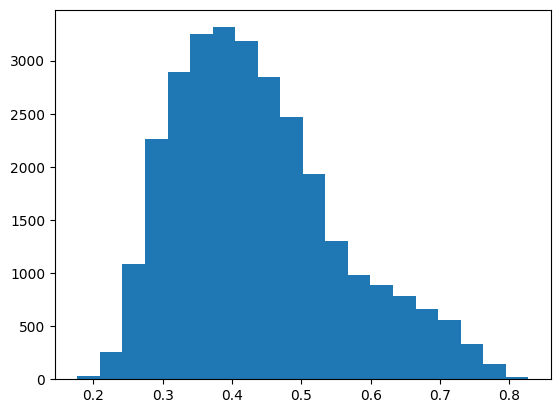

In [21]:
import matplotlib.pyplot as plt

columns = [i for i in list(pesudo_df.columns) if i not in ['filename','row_id']]
plt.hist(pesudo_df[columns].max(axis=1),bins=20)
plt.show()

In [ ]:
from joblib import Parallel, delayed

src_path = '/root/projects/BirdClef2025/data/train_soundscapes/'
def cut_audio(row):
    filename = row['filename']
    time = int(row['row_id'].split("_")[-1])
    src_path = '/root/projects/BirdClef2025/data/train_soundscapes/'
    audio,sr = sf.read(src_path+filename+'.ogg')
    audio = audio[int(sr*(time-20)):int(sr*time)]
    # write to file
    sf.write('/root/projects/BirdClef2025/data/train_soundscapes_20s/'+filename+'_'+str(time-20)+'s'+'.ogg',audio,sr)

Parallel(n_jobs=16)(delayed(cut_audio)(row) for idx,row in tqdm(pesudo_df.iterrows(),total=len(pesudo_df)))

In [ ]:
pesudo_df.to_csv('/root/projects/BirdClef2025/BirdCLEF2023-30th-place-solution-master/usefulFunc/pesudo_label.csv',index=False)

,filename,1139490,1192948,1194042,126247,1346504,134933,135045,1462711,1462737,...,yebfly1,yebsee1,yecspi2,yectyr1,yehbla2,yehcar1,yelori1,yeofly1,yercac1,ywcpar
0,H14_20230419_194500_20,0.039856,0.050610,0.021450,0.135370,0.037353,0.050595,0.035921,0.035678,0.033792,...,0.046644,0.043897,0.060841,0.043010,0.018933,0.044283,0.022309,0.055515,0.047921,0.034755
1,H14_20230419_194500_40,0.039204,0.053767,0.018886,0.183534,0.034303,0.043803,0.029952,0.041196,0.034524,...,0.043763,0.029680,0.072028,0.046652,0.018082,0.040963,0.023999,0.053049,0.034383,0.034693
2,H14_20230419_194500_60,0.041514,0.047979,0.021630,0.128029,0.043812,0.043734,0.033961,0.043843,0.033497,...,0.048065,0.036189,0.061385,0.046210,0.017485,0.040323,0.025551,0.052796,0.037217,0.029927
3,H8920_20230506_232500_20,0.029340,0.021441,0.014279,0.028116,0.041371,0.027163,0.033357,0.021038,0.020573,...,0.045423,0.041985,0.045383,0.035397,0.024128,0.046958,0.018976,0.065619,0.050949,0.023816
4,H8920_20230506_232500_40,0.031068,0.023448,0.017021,0.030412,0.053982,0.033638,0.032972,0.024485,0.022248,...,0.046414,0.038743,0.047794,0.041719,0.022986,0.047423,0.021199,0.067677,0.050112,0.025640
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133,O203_20230430_144500_40,0.039546,0.028259,0.034530,0.023417,0.061939,0.052884,0.036609,0.033402,0.034287,...,0.092388,0.053374,0.054444,0.063383,0.016620,0.041395,0.027593,0.144627,0.040573,0.022979
134,O203_20230430_144500_60,0.030000,0.026459,0.052903,0.026204,0.043470,0.039436,0.038566,0.032255,0.026885,...,0.059289,0.049773,0.092716,0.049872,0.027586,0.036707,0.036407,0.178143,0.066790,0.035376
135,H06_20230428_004000_20,0.025697,0.018549,0.019891,0.024615,0.039612,0.026531,0.042837,0.018941,0.016560,...,0.033631,0.037910,0.039419,0.053275,0.013736,0.037554,0.015657,0.064775,0.039433,0.020455
136,H06_20230428_004000_40,0.036602,0.023968,0.024497,0.025480,0.035517,0.032170,0.048233,0.024328,0.021707,...,0.042188,0.041105,0.040950,0.091273,0.018727,0.046638,0.022280,0.099585,0.061174,0.033573


In [97]:
# example df
df = pd.read_csv(CFG.train_path)
df.head()

,primary_label,secondary_labels,type,filename,collection,rating,url,latitude,longitude,scientific_name,common_name,author,license
0,1139490,[''],[''],1139490/CSA36385.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
1,1139490,[''],[''],1139490/CSA36389.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3206,-73.7128,Ragoniella pulchella,Ragoniella pulchella,Fabio A. Sarria-S,cc-by-nc-sa 4.0
2,1192948,[''],[''],1192948/CSA36358.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
3,1192948,[''],[''],1192948/CSA36366.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.2800,-73.8582,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
4,1192948,[''],[''],1192948/CSA36373.ogg,CSA,0.0,http://colecciones.humboldt.org.co/rec/sonidos...,7.3791,-73.7313,Oxyprora surinamensis,Oxyprora surinamensis,Fabio A. Sarria-S,cc-by-nc-sa 4.0
